# Import Necessary Libraries

In [1]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn
import time
import xgboost as xgb
import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from geopy.distance import geodesic

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [2]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,881707,2021-12-15,f,$93.00,$93.00,1,1125
1,910737,2021-12-15,t,$156.00,$156.00,2,1125
2,910737,2021-12-16,t,$156.00,$156.00,2,1125
3,910737,2021-12-17,f,$135.00,$135.00,2,1125
4,910737,2021-12-18,f,$135.00,$135.00,2,1125
...,...,...,...,...,...,...,...
958485,51875440,2022-12-10,t,$807.00,$807.00,5,365
958486,51875440,2022-12-11,t,$718.00,$718.00,5,365
958487,51875440,2022-12-12,t,$706.00,$706.00,5,365
958488,51875440,2022-12-13,t,$696.00,$696.00,5,365


In [3]:
#Check the info / types of data
raw_calendar_data.info()

#Pickle for later use
raw_calendar_data.to_pickle('../Supplements/Pickles/raw_asheville_calendar_data.pickle')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   listing_id      958490 non-null  int64 
 1   date            958490 non-null  object
 2   available       958490 non-null  object
 3   price           958319 non-null  object
 4   adjusted_price  958319 non-null  object
 5   minimum_nights  958490 non-null  int64 
 6   maximum_nights  958490 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 51.2+ MB


In [4]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  object        
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 51.2+ MB


In [5]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2021-12-15 00:00:00
Latest date of data set 2022-12-17 00:00:00


In [6]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

t    532541
f    425949
Name: available, dtype: int64

In [7]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

1    532541
0    425949
Name: available, dtype: int64

In [8]:
#Check if there are NaN values for a specific airbnb
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

47732580    171
Name: listing_id, dtype: int64

In [9]:
#Drop the specific airbnb
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 47732580)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [10]:
#Remove the '$' and ',' from prices then convert the values to integers
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

#Move the listing_id column to the begininning of the dataframe
id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_19409/3443857727.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,881707,93,2021-12-15,0,1,1125
1,910737,156,2021-12-15,1,2,1125
2,910737,156,2021-12-16,1,2,1125
3,910737,135,2021-12-17,0,2,1125
4,910737,135,2021-12-18,0,2,1125
...,...,...,...,...,...,...
958485,51875440,807,2022-12-10,1,5,365
958486,51875440,718,2022-12-11,1,5,365
958487,51875440,706,2022-12-12,1,5,365
958488,51875440,696,2022-12-13,1,5,365


In [11]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [12]:
#Pickle for later use
mod_calendar_data.to_pickle('../Supplements/Pickles/mod_asheville_calendar_data.pickle')

#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


## Listings Data

In [13]:
#Import opent the airbnb listings data set
raw_listings_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_listings_2021.csv')


#Pickle for later use
raw_listings_data.to_pickle('../Supplements/Pickles/raw_asheville_listings_data.pickle')

raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,108061,https://www.airbnb.com/rooms/108061,20211215062309,2021-12-15,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,...,4.79,4.84,4.48,NaN,f,2,2,0,0,0.71
1,155305,https://www.airbnb.com/rooms/155305,20211215062309,2021-12-15,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,...,4.76,4.93,4.53,NaN,t,7,1,2,4,2.75
2,156805,https://www.airbnb.com/rooms/156805,20211215062309,2021-12-15,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",https://a0.muscache.com/pictures/23447d55-fa7e...,746673,https://www.airbnb.com/users/show/746673,...,4.61,4.84,4.46,NaN,t,7,1,2,4,0.54
3,156926,https://www.airbnb.com/rooms/156926,20211215062309,2021-12-15,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",This is a top bunk in the mixed dorm room<br /...,NaN,https://a0.muscache.com/pictures/98f4e655-c4d6...,746673,https://www.airbnb.com/users/show/746673,...,4.80,4.78,4.78,NaN,t,7,1,2,4,2.36
4,160594,https://www.airbnb.com/rooms/160594,20211215062309,2021-12-15,Historic Grove Park,Come enjoy the beautiful Grove Park neighborho...,NaN,https://a0.muscache.com/pictures/92433837/d340...,769252,https://www.airbnb.com/users/show/769252,...,4.88,4.90,4.85,NaN,f,1,0,1,0,0.46


In [14]:
#Check the listings data information
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2626 non-null   int64  
 1   listing_url                                   2626 non-null   object 
 2   scrape_id                                     2626 non-null   int64  
 3   last_scraped                                  2626 non-null   object 
 4   name                                          2626 non-null   object 
 5   description                                   2621 non-null   object 
 6   neighborhood_overview                         2040 non-null   object 
 7   picture_url                                   2626 non-null   object 
 8   host_id                                       2626 non-null   int64  
 9   host_url                                      2626 non-null   o

In [15]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [16]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [17]:
#Remove other irrelevant columns
mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [18]:
#Verify all of the above columns were removed
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   neighbourhood           2041 non-null   object 
 9   latitude                2626 non-null   float64
 10  longitude               2626 non-null   float64
 11  room_type               2626 non-null   object 
 12  accommodates            2626 non-null   int64  
 13  bathrooms_text          2625 non-null   object 
 14  bedrooms                2463 non-null   

In [19]:
#Fill the missing neighborhood data with 'Asheville, North Carolina, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Asheville, North Carolina, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [20]:
#Split the neighbourhood column so that we are only left with the neighborhood name, not state and country
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2, 3, 4], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   latitude                2626 non-null   float64
 9   longitude               2626 non-null   float64
 10  room_type               2626 non-null   object 
 11  accommodates            2626 non-null   int64  
 12  bathrooms_text          2625 non-null   object 
 13  bedrooms                2463 non-null   float64
 14  beds                    2558 non-null   

In [21]:
#Fix the typos
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Ashville'],['Asheville'])
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Asheville '], 'Asheville')

#Drop the below neighborhoods as there is not enough data for each
neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] == 'Leicester') | 
                                 (mod_listing_data['neighborhood'] == 'Swannanoa') | 
                                 (mod_listing_data['neighborhood'] == 'Avery Creek') | 
                                 (mod_listing_data['neighborhood'] == 'Fairview') |
                                 (mod_listing_data['neighborhood'] == 'Limestone') |
                                 (mod_listing_data['neighborhood'] == 'Biltmore Forest')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

#Verify the neighborhoods that are left
mod_listing_data['neighborhood'].value_counts()

Asheville    2323
Arden         131
Woodfin        62
Candler        54
Fletcher       47
Name: neighborhood, dtype: int64

In [22]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text'], axis = 0)
#Verify there are no NaNs
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [23]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

1    1703
0     566
Name: host_is_superhost, dtype: int64

In [24]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1    1798
0     471
Name: host_identity_verified, dtype: int64

In [25]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [26]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [27]:
#Replace the bathrooms_text data that are only text values with the correct numeric value
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [28]:
#Create a bathrooms text test dataframe which splits the values based on spacing
test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])

In [29]:
#Create a function which will return a true or false value if the chosen amenity is present in the aribnb's amenities
#column
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [30]:
#Create a list of the target amenities and apply the function
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [31]:
#Rename the 'id' column to 'listing_id' so it is consistent with the calendar data
mod_listing_data['listing_id'] = mod_listing_data['id']

#Remove the id column
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)

#Move the listing_id column to the start
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)

#Pickle for later use
mod_listing_data.to_pickle('../Supplements/Pickles/mod_asheville_listing_data.pickle')
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

## Combine Calendar Data and Listings Data

In [32]:
#Combine the mod_listing_data and mod_calendar data
asheville_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')

#Pickle for later use
asheville_data.to_pickle('../Supplements/Pickles/asheville_data.pickle')

### Drop Outliers

In [33]:
asheville_data.describe()

,listing_id,host_id,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,...,instant_bookable,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price
count,8.278210e+05,8.278210e+05,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,...,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827821.000000,827820.000000
mean,3.253828e+07,1.177150e+08,0.750441,0.792768,35.576168,-82.557438,4.529099,1.876101,2.451056,4.791443,...,0.582452,1.511684,0.869048,0.965166,0.878748,0.772928,0.562169,0.550705,0.850088,204.751260
std,1.495866e+07,1.131017e+08,0.432758,0.405323,0.048445,0.047573,2.792271,1.099580,1.779212,12.610611,...,0.493155,0.801355,0.337348,0.183358,0.326420,0.418940,0.496120,0.497423,0.356985,190.123675
min,1.080610e+05,6.266700e+04,0.000000,0.000000,35.423420,-82.691050,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,2.074753e+07,2.208448e+07,1.000000,1.000000,35.561180,-82.591330,2.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,99.000000
50%,3.454189e+07,8.551048e+07,1.000000,1.000000,35.588100,-82.556370,4.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,150.000000
75%,4.588397e+07,1.674293e+08,1.000000,1.000000,35.604530,-82.523620,6.000000,2.000000,3.000000,2.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,246.000000
max,5.373538e+07,4.331869e+08,1.000000,1.000000,35.656090,-82.459420,16.000000,9.000000,21.000000,365.000000,...,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5950.000000


In [34]:
#Drop the very few NaNs
asheville_data = asheville_data.dropna()

#Verify the NaNs were dropped
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827820 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827820 non-null  int64         
 1   listing_url             827820 non-null  object        
 2   name                    827820 non-null  object        
 3   picture_url             827820 non-null  object        
 4   host_id                 827820 non-null  int64         
 5   host_url                827820 non-null  object        
 6   host_is_superhost       827820 non-null  int64         
 7   host_identity_verified  827820 non-null  int64         
 8   latitude                827820 non-null  float64       
 9   longitude               827820 non-null  float64       
 10  room_type               827820 non-null  object        
 11  accommodates            827820 non-null  int64         
 12  bedrooms                827820

In [35]:
#Check the date column, appears there two 'outliers' which are likely imput errors
asheville_data['date'].value_counts()

2022-06-17    2268
2022-08-20    2268
2022-08-18    2268
2022-08-17    2268
2022-08-16    2268
              ... 
2021-12-16    2266
2021-12-17    2266
2022-12-15       2
2022-12-16       2
2022-12-17       2
Name: date, Length: 368, dtype: int64

In [36]:
#Replace the input errors
asheville_data['date'] = asheville_data['date'].replace(['2022-12-15'],['2021-12-15'])
asheville_data['date'] = asheville_data['date'].replace(['2022-12-16'],['2021-12-16'])
asheville_data['date'] = asheville_data['date'].replace(['2022-12-17'],['2021-12-17'])

#Verify the dates were adjusted correctly
asheville_data['date'].value_counts()

2021-12-15    2268
2022-08-23    2268
2022-08-21    2268
2022-08-20    2268
2022-08-19    2268
              ... 
2022-04-14    2268
2022-04-13    2268
2022-04-12    2268
2022-04-11    2268
2022-12-14    2268
Name: date, Length: 365, dtype: int64

In [37]:
#Include bathrooms which are only between 1 and 5
asheville_data = asheville_data[asheville_data['bathrooms'] <= 5]
asheville_data = asheville_data[asheville_data['bathrooms'] >= 1]

#Include bedrooms which are less than or equal to 6 and beds which are less than or equal to 11
asheville_data = asheville_data[asheville_data['bedrooms'] <= 6]
asheville_data = asheville_data[asheville_data['beds'] <= 11]

#Exclude hotel rooms and shared rooms
asheville_data = asheville_data[asheville_data['room_type'] != 'Hotel room']
asheville_data = asheville_data[asheville_data['room_type'] != 'Shared room']

#Only include daily prices which are less than $1000
asheville_data = asheville_data[asheville_data['daily_price'] <= 1000]

In [38]:
#Reset the index and drop the index column
asheville_data = asheville_data.reset_index()
asheville_data = asheville_data.drop(['index'], axis = 1)

In [39]:
#Test the geodesic function
origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles) # 14.64994773134371

23576.805481751613
23.576805481751613
14.64994773134371


In [40]:
#Zip the latitude and longitude columns to a new column called 'coords'
asheville_data['coords'] = list(zip(asheville_data['latitude'],asheville_data['longitude']))

#Create variables for popular tourist attractions
biltmore = (35.54108101423884, -82.55210010496437) 
downtown = (35.60405939066325, -82.54533225431588)

#Calculate the distance in miles from the airbnb coords to the tourist attractions
for idx, coords in enumerate(asheville_data['coords']):
        asheville_data.loc[idx,'distance_to_biltmore'] = geodesic(coords, biltmore).miles
        asheville_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
    

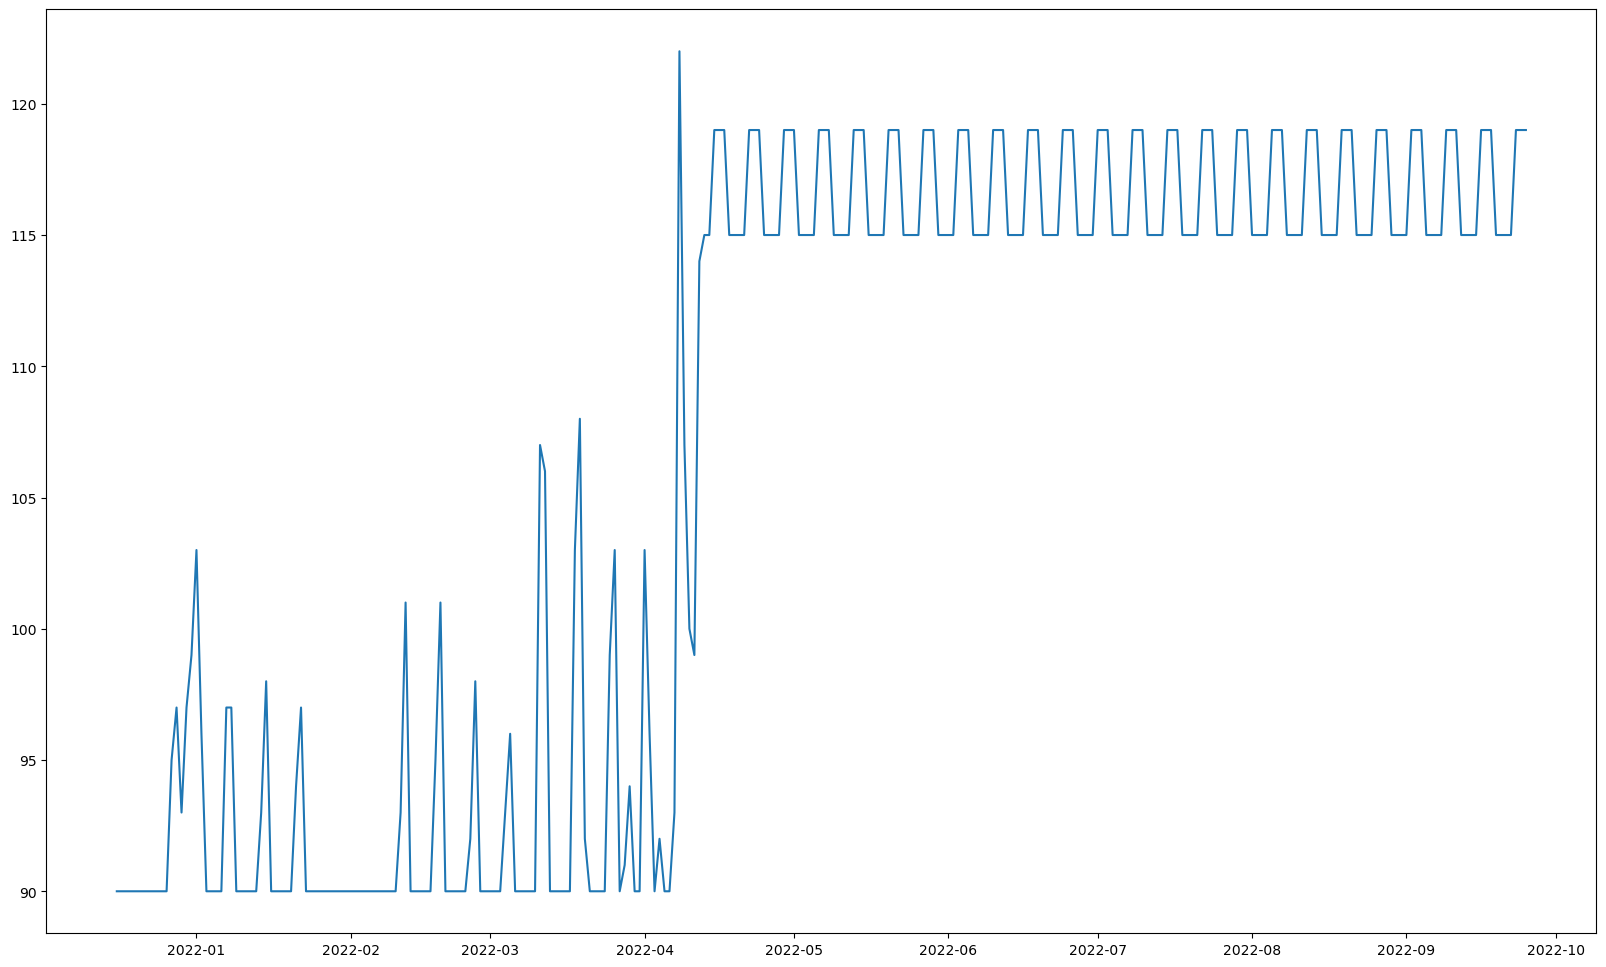

In [41]:
#Graph one airbnb's 365 daily price to view any seasonality
graphing_one_bnb = asheville_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.savefig('../Images/Asheville_Sample_BnB.jpeg')
plt.show()

In [42]:
#Create a modeling data dataframe which exculdes other irrelevant columns
asheville_modeling_data = asheville_data.drop(['listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
asheville_modeling_data.head()

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_biltmore,distance_to_downtown
0,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-15,"(35.6067, -82.55563)",4.52826,0.607702
1,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-16,"(35.6067, -82.55563)",4.52826,0.607702
2,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-17,"(35.6067, -82.55563)",4.52826,0.607702
3,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-18,"(35.6067, -82.55563)",4.52826,0.607702
4,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-19,"(35.6067, -82.55563)",4.52826,0.607702


In [43]:
#Create new columns for the day of the week, month, and week
asheville_modeling_data['day_of_week'] = asheville_modeling_data['date'].dt.dayofweek
asheville_modeling_data['month'] = asheville_modeling_data['date'].dt.month
asheville_modeling_data['week'] = asheville_modeling_data['date'].dt.week

#Drop the date column
asheville_modeling_data = asheville_modeling_data.drop(['date'], axis = 1)

#Pickle for later use
# asheville_modeling_data.to_pickle('../Supplements/streamlit/asheville_modeling_data.pickle')
# asheville_modeling_data.to_pickle('../Supplements/streamlit/asheville_modeling_data.pkl')
with open('../Supplements/streamlit/asheville_modeling_data.pkl', 'wb') as f:
    pickle.dump(asheville_modeling_data, f)

#Verify the new columns
asheville_modeling_data.info()

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_19409/2305950891.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  asheville_modeling_data['week'] = asheville_modeling_data['date'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811427 entries, 0 to 811426
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   listing_id            811427 non-null  int64  
 1   host_is_superhost     811427 non-null  int64  
 2   room_type             811427 non-null  object 
 3   accommodates          811427 non-null  int64  
 4   bedrooms              811427 non-null  float64
 5   beds                  811427 non-null  float64
 6   neighborhood          811427 non-null  object 
 7   bathrooms             811427 non-null  float64
 8   Air conditioning      811427 non-null  int64  
 9   Wifi                  811427 non-null  int64  
 10  TV                    811427 non-null  int64  
 11  Kitchen               811427 non-null  int64  
 12  Washer                811427 non-null  int64  
 13  Dryer                 811427 non-null  int64  
 14  Heating               811427 non-null  int64  
 15  

## Baseline Model - Neural Network

In [44]:
#One hot encode the categorical columns
baseline_model_sklearn = asheville_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse = False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                                      columns = ohe.get_feature_names_out())
baseline_model_cat_ohe

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,neighborhood_Asheville,neighborhood_Candler,neighborhood_Fletcher,neighborhood_Woodfin,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
811425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
#Create a data frame of numeric columns
baseline_model_numeric = asheville_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 
                                                  'bedrooms', 'beds', 'bathrooms', 'Air conditioning', 'Wifi', 'TV', 
                                                  'Kitchen', 'Washer', 'Dryer', 'Heating', 'week']]

#Merge the one hot encoded dataframe and the numeric columns
baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')
baseline_model_comb_ohe

,listing_id,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,53735375,165.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811423,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811424,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
811425,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
#Create a baseline X and y variable
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

#Split the data set to train and test
baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)
#Further split the data to a validation set
baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#Instantiate a new scaler and scale/transform the data
scaler = StandardScaler()
baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

In [47]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Create a sequential model, add a flatten, a dense layer, followed by a dropout and another dense layer
baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

Metal device set to: Apple M1 Pro
Epoch 1/50


2023-01-06 10:25:45.840489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-06 10:25:45.840629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-06 10:25:46.005108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  8/586 [..............................] - ETA: 4s - loss: 192.4616 - mse: 56054.3164 - mae: 192.3812  

2023-01-06 10:25:46.171742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 191.3297 - mse: 56055.6406 - mae: 191.2443

2023-01-06 10:25:50.100708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 4s 7ms/step - loss: 191.3297 - mse: 56055.6406 - mae: 191.2443 - val_loss: 190.6713 - val_mse: 55885.4609 - val_mae: 190.5760
Epoch 2/50
586/586 [==============================] - 4s 6ms/step - loss: 189.4757 - mse: 55384.7891 - mae: 189.3626 - val_loss: 188.6735 - val_mse: 55154.4766 - val_mae: 188.5389
Epoch 3/50
586/586 [==============================] - 4s 6ms/step - loss: 187.2882 - mse: 54588.9766 - mae: 187.1253 - val_loss: 186.3229 - val_mse: 54295.5078 - val_mae: 186.1283
Epoch 4/50
586/586 [==============================] - 4s 6ms/step - loss: 184.7651 - mse: 53683.0391 - mae: 184.5329 - val_loss: 183.6392 - val_mse: 53323.9453 - val_mae: 183.3665
Epoch 5/50
586/586 [==============================] - 4s 6ms/step - loss: 181.8516 - mse: 52650.7383 - mae: 181.5328 - val_loss: 180.5097 - val_mse: 52195.5820 - val_mae: 180.1413
Epoch 6/50
586/586 [==============================] - 4s 6ms/step - loss: 178.4665 - mse: 51453.4648 - mae: 178

Epoch 47/50
586/586 [==============================] - 4s 6ms/step - loss: 93.3426 - mse: 17951.1758 - mae: 90.6928 - val_loss: 74.3639 - val_mse: 13566.8027 - val_mae: 71.7345
Epoch 48/50
586/586 [==============================] - 4s 6ms/step - loss: 93.0386 - mse: 17869.0566 - mae: 90.4290 - val_loss: 74.1995 - val_mse: 13523.0479 - val_mae: 71.6089
Epoch 49/50
586/586 [==============================] - 4s 6ms/step - loss: 92.9665 - mse: 17876.3555 - mae: 90.3959 - val_loss: 74.0499 - val_mse: 13485.7188 - val_mae: 71.4981
Epoch 50/50
586/586 [==============================] - 4s 6ms/step - loss: 92.6603 - mse: 17789.0234 - mae: 90.1269 - val_loss: 73.8634 - val_mse: 13432.0928 - val_mae: 71.3479


In [48]:
#Print the train and test results of the model
baseline_model_nn_results_train = baseline_model_nn.evaluate(baseline_model_X_train_scaled, 
                                                             baseline_model_y_train.values)
baseline_model_nn_results_test = baseline_model_nn.evaluate(baseline_model_X_test_scaled, 
                                                            baseline_model_y_test.values)

print(f'Baseline Model Neural Network Train Results: {baseline_model_nn_results_train}')
print(f'Baseline Model Neural Network Test Results: {baseline_model_nn_results_test}')

4565/4565 [==============================] - 19s 4ms/step - loss: 73.0739 - mse: 13057.1973 - mae: 70.5586
Baseline Model Neural Network Train Results: [73.4818344116211, 13224.02734375, 70.96642303466797]
Baseline Model Neural Network Test Results: [73.0738754272461, 13057.197265625, 70.55860900878906]


In [49]:
#Print the model's summary
baseline_model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 86)                0         
                                                                 
 dense (Dense)               (None, 16)                1392      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Create the train and test predictions
baseline_model_nn_train_preds = baseline_model_nn.predict(baseline_model_X_train_scaled)
baseline_model_nn_test_preds = baseline_model_nn.predict(baseline_model_X_test_scaled)

2023-01-06 10:30:27.009502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


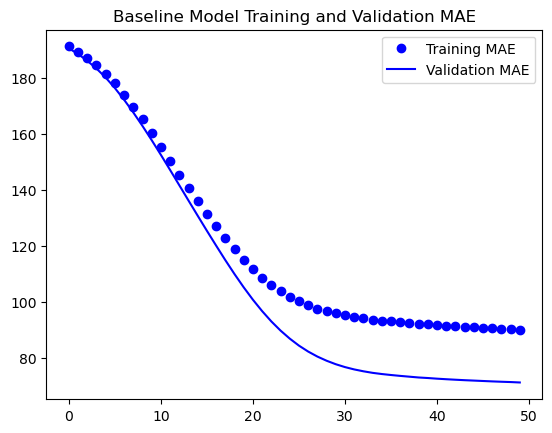

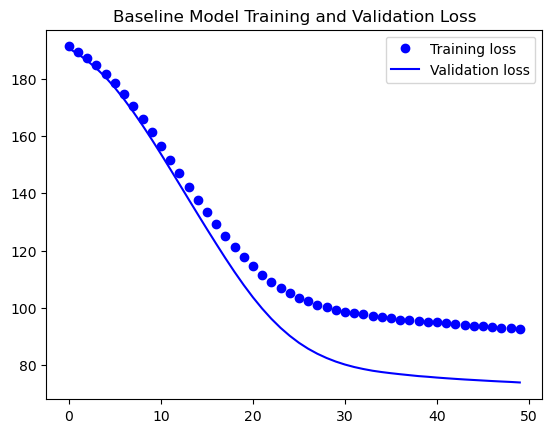

In [51]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_mae = baseline_model_nn_histoire.history['mae']
baseline_model_val_mae = baseline_model_nn_histoire.history['val_mae']
baseline_model_loss = baseline_model_nn_histoire.history['loss']
baseline_model_val_loss = baseline_model_nn_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_mae))

plt.plot(baseline_model_epochs, baseline_model_mae, 'bo', label = 'Training MAE')
plt.plot(baseline_model_epochs, baseline_model_val_mae, 'b', label = 'Validation MAE')
plt.title('Baseline Model Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.savefig('../Images/Asheville_Baseline_Model_Training_and_Validation_Loss.jpeg')
plt.show()

In [52]:
baseline_model_train_MAE = mean_absolute_error(baseline_model_y_train.values, baseline_model_nn_train_preds)
print(f'Baseline Model train MAE w/ preds ${baseline_model_train_MAE}')
with open('../Supplements/Pickles/baseline_asheville_model_train_MAE.pickle', 'wb') as b:
    pickle.dump(baseline_model_train_MAE, b)

baseline_model_test_MAE = mean_absolute_error(baseline_model_y_test.values, baseline_model_nn_test_preds)
print(f'Baseline Model test MAE w/ preds {baseline_model_test_MAE}')
with open('../Supplements/Pickles/baseline_asheville_model_test_MAE.pickle', 'wb') as b:
    pickle.dump(baseline_model_test_MAE, b)

baseline_model_train_explained_var = explained_variance_score(baseline_model_y_train.values, baseline_model_nn_train_preds)
print(f'Baseline Model explained variance train score {baseline_model_train_explained_var}')
with open('../Supplements/Pickles/baseline_asheville_model_train_explained_var.pickle', 'wb') as b:
    pickle.dump(baseline_model_train_explained_var, b)

baseline_model_test_explained_var = explained_variance_score(baseline_model_y_test.values, baseline_model_nn_test_preds)
print(f'Baseline Model explained variance test score {baseline_model_test_explained_var}')
with open('../Supplements/Pickles/baseline_asheville_model_test_explained_var.pickle', 'wb') as b:
    pickle.dump(baseline_model_test_explained_var, b)

Baseline Model train MAE w/ preds $70.96652884091704
Baseline Model test MAE w/ preds 70.5585371014211
Baseline Model explained variance train score 0.4238353698986217
Baseline Model explained variance test score 0.42755658221390447


## Model 2 - Neural Network

In [53]:
#One hot encode the categorical columns
model2_sklearn = asheville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = asheville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_biltmore', 'distance_to_downtown']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [54]:
#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [55]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model, add several convolutional 1D layers, flatten and dense layers
model2_nn = models.Sequential()
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 3))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 3))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])


# Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/120


2023-01-06 10:31:08.170556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 164.5715 - mse: 47652.8242 - mae: 164.4412

2023-01-06 10:31:19.547068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 12s 19ms/step - loss: 164.5715 - mse: 47652.8242 - mae: 164.4412 - val_loss: 124.3549 - val_mse: 34695.5273 - val_mae: 124.1980
Epoch 2/120
586/586 [==============================] - 11s 19ms/step - loss: 94.1266 - mse: 22911.7324 - mae: 93.9394 - val_loss: 79.9154 - val_mse: 17290.9805 - val_mae: 79.7075
Epoch 3/120
586/586 [==============================] - 11s 19ms/step - loss: 77.4179 - mse: 15061.5459 - mae: 77.2029 - val_loss: 72.3947 - val_mse: 13759.8164 - val_mae: 72.1754
Epoch 4/120
586/586 [==============================] - 11s 19ms/step - loss: 73.2917 - mse: 13257.1309 - mae: 73.0706 - val_loss: 68.6015 - val_mse: 12312.4570 - val_mae: 68.3778
Epoch 5/120
586/586 [==============================] - 11s 18ms/step - loss: 71.0594 - mse: 12433.2832 - mae: 70.8340 - val_loss: 66.5933 - val_mse: 11618.4561 - val_mae: 66.3671
Epoch 6/120
586/586 [==============================] - 11s 19ms/step - loss: 69.9684 - mse: 12034.5186 - mae: 69.

Epoch 47/120
586/586 [==============================] - 11s 19ms/step - loss: 62.9217 - mse: 9773.4072 - mae: 62.6632 - val_loss: 59.1435 - val_mse: 9034.1113 - val_mae: 58.8847
Epoch 48/120
586/586 [==============================] - 11s 18ms/step - loss: 62.8620 - mse: 9762.6543 - mae: 62.6032 - val_loss: 58.9885 - val_mse: 9043.0371 - val_mae: 58.7295
Epoch 49/120
586/586 [==============================] - 11s 18ms/step - loss: 62.7425 - mse: 9727.9258 - mae: 62.4835 - val_loss: 59.0202 - val_mse: 8962.6133 - val_mae: 58.7606
Epoch 50/120
586/586 [==============================] - 11s 19ms/step - loss: 62.7376 - mse: 9723.4932 - mae: 62.4784 - val_loss: 59.0308 - val_mse: 9054.9434 - val_mae: 58.7716
Epoch 51/120
586/586 [==============================] - 11s 19ms/step - loss: 62.6903 - mse: 9702.0859 - mae: 62.4307 - val_loss: 58.9462 - val_mse: 9078.6152 - val_mae: 58.6865
Epoch 52/120
586/586 [==============================] - 11s 18ms/step - loss: 62.6455 - mse: 9692.8408 - mae: 

586/586 [==============================] - 11s 19ms/step - loss: 61.4131 - mse: 9315.9785 - mae: 61.1568 - val_loss: 57.2861 - val_mse: 8508.7881 - val_mae: 57.0297
Epoch 94/120
586/586 [==============================] - 11s 18ms/step - loss: 61.3692 - mse: 9299.2070 - mae: 61.1128 - val_loss: 57.3467 - val_mse: 8506.4590 - val_mae: 57.0902
Epoch 95/120
586/586 [==============================] - 10s 18ms/step - loss: 61.2718 - mse: 9264.1045 - mae: 61.0154 - val_loss: 57.1506 - val_mse: 8479.7969 - val_mae: 56.8942
Epoch 96/120
586/586 [==============================] - 11s 18ms/step - loss: 61.3331 - mse: 9309.6348 - mae: 61.0770 - val_loss: 57.2781 - val_mse: 8524.4238 - val_mae: 57.0220
Epoch 97/120
586/586 [==============================] - 11s 18ms/step - loss: 61.2546 - mse: 9286.4297 - mae: 60.9987 - val_loss: 57.2384 - val_mse: 8538.7871 - val_mae: 56.9825
Epoch 98/120
586/586 [==============================] - 11s 18ms/step - loss: 61.2680 - mse: 9278.8975 - mae: 61.0121 - val

In [56]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

4565/4565 [==============================] - 25s 5ms/step - loss: 56.5045 - mse: 8228.2539 - mae: 56.2492
Model 2 Neural Network Train Results: [56.556396484375, 8242.388671875, 56.30116653442383]
Model 2 Neural Network Test Results: [56.50446701049805, 8228.25390625, 56.249237060546875]


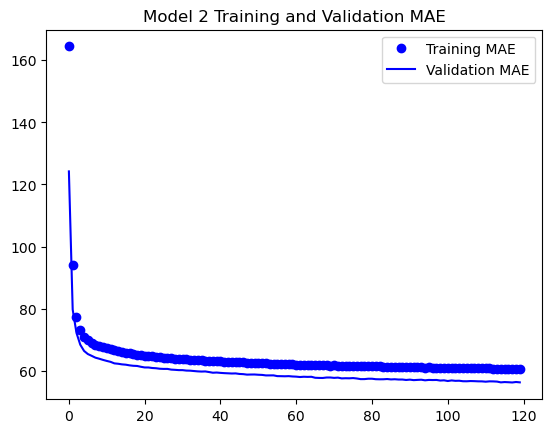

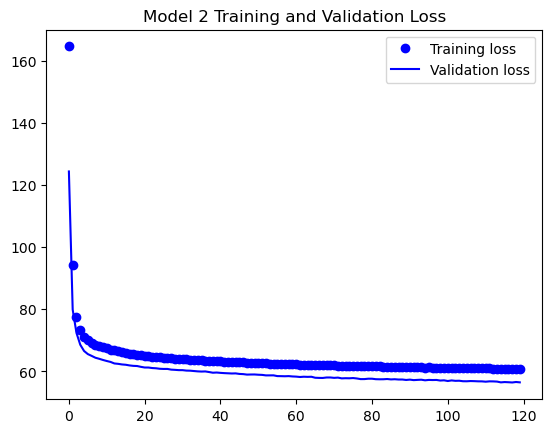

In [57]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.savefig('../Images/Asheville_Model_2_Training_and_Validation_Loss.jpeg')
plt.show();

In [58]:
#Create variables for the model's train and test predictions
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2023-01-06 10:54:56.802743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [59]:
model2_train_MAE = mean_absolute_error(model2_y_train.values, model2_nn_train_preds)
print(f'Model 2 train MAE w/ preds {model2_train_MAE}')
with open('../Supplements/Pickles/model2_asheville_train_MAE.pickle', 'wb') as b:
    pickle.dump(model2_train_MAE, b)

model2_test_MAE = mean_absolute_error(model2_y_test.values, model2_nn_test_preds)
print(f'Model 2 test MAE w/ preds {model2_test_MAE}')
with open('../Supplements/Pickles/model2_asheville_test_MAE.pickle', 'wb') as b:
    pickle.dump(model2_test_MAE, b)

model2_train_explained_var = explained_variance_score(model2_y_train.values, model2_nn_train_preds)
print(f'Model 2 explained variance train score {model2_train_explained_var}')
with open('../Supplements/Pickles/model2_asheville_train_explained_var.pickle', 'wb') as b:
    pickle.dump(model2_train_explained_var, b)

model2_test_explained_var = explained_variance_score(model2_y_test.values, model2_nn_test_preds)
print(f'Model 2 explained variance test score {model2_test_explained_var}')
with open('../Supplements/Pickles/model2_asheville_test_explained_var.pickle', 'wb') as b:
    pickle.dump(model2_test_explained_var, b)    

Model 2 train MAE w/ preds 56.301053303817554
Model 2 test MAE w/ preds 56.24923460831425
Model 2 explained variance train score 0.5911267267044836
Model 2 explained variance test score 0.5908157821013085


## Model 3 - Random Forest

In [60]:
%%time

#Create a model 3 X and y variable 
model3_X = asheville_modeling_data.drop(['daily_price', 'listing_id', 'coords'], axis = 1)
model3_y = asheville_modeling_data['daily_price']

#Train, test, split the X and y variables
model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

#Create a list of numeric columns
model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

#Create a list of nominal columns
model3_nominal_cols = ['room_type', 'neighborhood', 'day_of_week', 'month', 'week']

#Scale the numeric columns
model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

#One hot encode the nominal columns
model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse = False))])

#Column tranform the two pipelines
ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

#Create a final pipeline with the column transformer and random forest regressor model
model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)


/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: user 6min 10s, sys: 2.09 s, total: 6min 12s
Wall time: 6min 12s


In [61]:
# model3_results.to_pickle('../Supplements/Pickles/streamlit_model3_results.pickle')
# with open('../Supplements/Pickles/streamlit_model3_results.pickle', 'wb') as f:
#     pickle.dump(model3_results, f)
joblib.dump(model3_results, '../Supplements/streamlit/streamlit_model3_results.joblib')

['../Supplements/streamlit/streamlit_model3_results.joblib']

In [62]:
model3_X_train['room_type'].value_counts()

Entire home/apt    554751
Private room        94390
Name: room_type, dtype: int64

In [63]:
model3_X_train['bathrooms'].dtype

dtype('float64')

Model 3 train accuracy 0.996788936864413
Model 3 train MSE 7.903362306580812
Model 3 train MAE 1.886523026549352


Model 3 test accuracy 0.9815048059367117
Model 3 test MSE 18.94719844339369
Model 3 test MAE 4.796450092559678


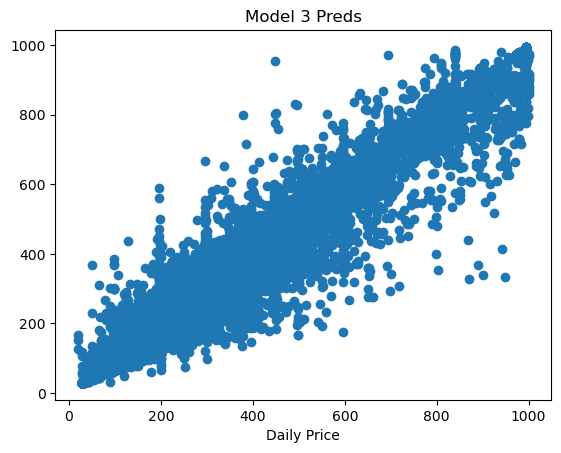

In [64]:
model3_train_preds = model3_final_pipe.predict(model3_X_train)
model3_test_preds = model3_final_pipe.predict(model3_X_test)

model3_train_accuracy = model3_final_pipe.score(model3_X_train, model3_y_train)
with open('../Supplements/Pickles/model3_asheville_train_accuracy.pickle', 'wb') as b:
    pickle.dump(model3_train_accuracy, b)
    
model3_train_MSE = mean_squared_error(model3_y_train, model3_train_preds, squared = False)
with open('../Supplements/Pickles/model3_asheville_train_MSE.pickle', 'wb') as b:
    pickle.dump(model3_train_MSE, b)

model3_train_MAE = mean_absolute_error(model3_y_train, model3_train_preds)
with open('../Supplements/Pickles/model3_asheville_train_MAE.pickle', 'wb') as b:
    pickle.dump(model3_train_MAE, b)

model3_test_accuracy = model3_final_pipe.score(model3_X_test, model3_y_test)
with open('../Supplements/Pickles/model3_asheville_test_accuracy.pickle', 'wb') as b:
    pickle.dump(model3_test_accuracy, b)

model3_test_MSE = mean_squared_error(model3_y_test, model3_test_preds, squared = False)
with open('../Supplements/Pickles/model3_asheville_test_MSE.pickle', 'wb') as b:
    pickle.dump(model3_test_MSE, b)

model3_test_MAE = mean_absolute_error(model3_y_test, model3_test_preds)
with open('../Supplements/Pickles/model3_asheville_test_MAE.pickle', 'wb') as b:
    pickle.dump(model3_test_MAE, b)

print(f'Model 3 train accuracy {model3_train_accuracy}')
print(f'Model 3 train MSE {model3_train_MSE}')
print(f'Model 3 train MAE {model3_train_MAE}')
print(f'\n')
print(f'Model 3 test accuracy {model3_test_accuracy}')
print(f'Model 3 test MSE {model3_test_MSE}')
print(f'Model 3 test MAE {model3_test_MAE}')

plt.scatter(model3_y_test, model3_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 3 Preds')
plt.savefig('../Images/Asheville_Model3_Preds')

## Model 4 - Random Forest

In [ ]:
model4_X = asheville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model4_y = asheville_modeling_data['daily_price']

model4_X_train, model4_X_test, model4_y_train, model4_y_test = train_test_split(model4_X, 
                                                                                model4_y, 
                                                                                test_size = 0.2)

model4_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model4_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model4_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model4_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model4_nominal_pipeline, model4_nominal_cols ),
                        ('numpipe', model4_numeric_pipeline, model4_numeric_cols)])

model4_final_pipe = Pipeline([('preprocess', ct),
                              ('rf', RandomForestRegressor(min_samples_leaf = 23,
                                                          max_depth = 23,
                                                           min_samples_split = 23))])

model4_final_pipe.fit(model4_X_train, model4_y_train)

In [ ]:
model4_train_preds = model4_final_pipe.predict(model4_X_train)
model4_test_preds = model4_final_pipe.predict(model4_X_test)

model4_train_accuracy = model4_final_pipe.score(model4_X_train, model4_y_train)
with open('../Supplements/Pickles/model4_asheville_train_accuracy.pickle', 'wb') as b:
    pickle.dump(model4_train_accuracy, b)
    
model4_train_MSE = mean_squared_error(model4_y_train, model4_train_preds, squared = False)
with open('../Supplements/Pickles/model4_asheville_train_MSE.pickle', 'wb') as b:
    pickle.dump(model4_train_MSE, b)

model4_train_MAE = mean_absolute_error(model4_y_train, model4_train_preds)
with open('../Supplements/Pickles/model4_asheville_train_MAE.pickle', 'wb') as b:
    pickle.dump(model4_train_MAE, b)

model4_test_accuracy = model4_final_pipe.score(model4_X_test, model4_y_test)
with open('../Supplements/Pickles/model4_asheville_test_accuracy.pickle', 'wb') as b:
    pickle.dump(model4_test_accuracy, b)

model4_test_MSE = mean_squared_error(model4_y_test, model4_test_preds, squared = False)
with open('../Supplements/Pickles/model4_asheville_test_MSE.pickle', 'wb') as b:
    pickle.dump(model4_test_MSE, b)

model4_test_MAE = mean_absolute_error(model4_y_test, model4_test_preds)
with open('../Supplements/Pickles/model4_asheville_test_MAE.pickle', 'wb') as b:
    pickle.dump(model4_test_MAE, b)

print(f'Model 4 train accuracy {model4_train_accuracy}')
print(f'Model 4 train MSE {model4_train_MSE}')
print(f'Model 4 train MAE {model4_train_MAE}')
print(f'\n')
print(f'Model 4 test accuracy {model4_test_accuracy}')
print(f'Model 4 test MSE {model4_test_MSE}')
print(f'Model 4 test MAE {model4_test_MAE}')


plt.scatter(model4_y_test, model4_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 4 Preds')
plt.savefig('../Images/Asheville_Model4_Preds')

## Model 5 - XGBoost

In [ ]:
model5_X = asheville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model5_y = asheville_modeling_data['daily_price']

model5_X_train, model5_X_test, model5_y_train, model5_y_test = train_test_split(model5_X, 
                                                                                model5_y, 
                                                                                test_size = 0.2)

model5_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model5_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model5_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model5_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model5_nominal_pipeline, model5_nominal_cols ),
                        ('numpipe', model5_numeric_pipeline, model5_numeric_cols)])

model5_final_pipe = Pipeline([('preprocess', ct),
                              ('xg', xgb.XGBRegressor(n_estimators = 1000, 
                                                  max_depth = 7, 
                                                  eta = 0.1, 
                                                  subsample = 0.7, 
                                                  colsample_bytree = 0.8))])

model5_final_pipe.fit(model5_X_train, model5_y_train)

In [ ]:
model5_train_preds = model5_final_pipe.predict(model5_X_train)
model5_test_preds = model5_final_pipe.predict(model5_X_test)

model5_train_accuracy = model5_final_pipe.score(model5_X_train, model5_y_train)
with open('../Supplements/Pickles/model5_asheville_train_accuracy.pickle', 'wb') as b:
    pickle.dump(model5_train_accuracy, b)
    
model5_train_MSE = mean_squared_error(model5_y_train, model5_train_preds, squared = False)
with open('../Supplements/Pickles/model5_asheville_train_MSE.pickle', 'wb') as b:
    pickle.dump(model5_train_MSE, b)

model5_train_MAE = mean_absolute_error(model5_y_train, model5_train_preds)
with open('../Supplements/Pickles/model5_asheville_train_MAE.pickle', 'wb') as b:
    pickle.dump(model5_train_MAE, b)

model5_test_accuracy = model5_final_pipe.score(model5_X_test, model5_y_test)
with open('../Supplements/Pickles/model5_asheville_test_accuracy.pickle', 'wb') as b:
    pickle.dump(model5_test_accuracy, b)

model5_test_MSE = mean_squared_error(model5_y_test, model5_test_preds, squared = False)
with open('../Supplements/Pickles/model5_asheville_test_MSE.pickle', 'wb') as b:
    pickle.dump(model5_test_MSE, b)

model5_test_MAE = mean_absolute_error(model5_y_test, model5_test_preds)
with open('../Supplements/Pickles/model5_asheville_test_MAE.pickle', 'wb') as b:
    pickle.dump(model5_test_MAE, b)

print(f'Model 5 train accuracy {model5_train_accuracy}')
print(f'Model 5 train MSE {model5_train_MSE}')
print(f'Model 5 train MAE {model5_train_MAE}')
print(f'\n')
print(f'Model 5 test accuracy {model5_test_accuracy}')
print(f'Model 5 test MSE {model5_test_MSE}')
print(f'Model 5 test MAE {model5_test_MAE}')

plt.scatter(model5_y_test, model5_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 5 Preds')
plt.savefig('../Images/Asheville_Model5_Preds')

## Testing Predictions

In [ ]:
host_superhost = input('Host is Superhost (Y/N): ')
room_type = input('Room Type (Entire home/apt or Private room)')
accommodates = input('Accomodates (1-16) Guests: ')
num_of_bedrooms = input('Number of Bedrooms: ')
num_of_beds = input('Number of Beds: ')
select_neighborhood = input('Neighborhood (Asheville/Candler/Fletcher/Woodfin): ')
num_of_bathrooms = input('Number of Bathrooms: ')
check_AC = input('AC (Y/N): ')
check_wifi = input('Wifi (Y/N): ')
check_TV = input('TV (Y/N): ')
check_kitchen = input('Kitchen (Y/N): ')
check_washer = input('Washer (Y/N): ')
check_dryer = input('Dryer (Y/N): ')
check_heating = input('Heating (Y/N): ')
select_latitude = input('Latitude: ')
select_longitude = input('Longitude: ')
checkin_date = input('Check-in Date: ')
checkout_date = input('Check-out Date: ')

In [ ]:
def yes_no_conversion(input):
    if input == 'Y':
        return 1
    else:
        return 0

In [ ]:
conv_long = float(select_longitude)
conv_lat = float(select_latitude)
test_coords = list((conv_lat, conv_long))
predicted_checkin_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
#                           test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkin_date).dayofweek,
                          pd.to_datetime(checkin_date).month,
                          pd.to_datetime(checkin_date).week]

In [ ]:
checkin_prediction_df = pd.DataFrame(predicted_checkin_list).T
checkin_prediction_df = checkin_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
#                                       14: 'coords',
                                      14: 'distance_to_biltmore',
                                      15: 'distance_to_downtown',
                                      16: 'day_of_week',
                                      17: 'month',
                                      18: 'week'}, axis = 1)

checkin_prediction_df

In [ ]:
predicted_checkout_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
#                           test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkout_date).dayofweek,
                          pd.to_datetime(checkout_date).month,
                          pd.to_datetime(checkout_date).week]

In [ ]:
checkout_prediction_df = pd.DataFrame(predicted_checkout_list).T
checkout_prediction_df = checkout_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
#                                       14: 'coords',
                                      14: 'distance_to_biltmore',
                                      15: 'distance_to_downtown',
                                      16: 'day_of_week',
                                      17: 'month',
                                      18: 'week'}, axis = 1)

checkout_prediction_df

In [ ]:
checkin_price = float(model3_final_pipe.predict(checkin_prediction_df))
checkout_price = float(model3_final_pipe.predict(checkout_prediction_df))
average_price = (checkin_price + checkout_price) / 2
total_stay_days = (pd.to_datetime(checkout_date) - pd.to_datetime(checkin_date)).days

print(f'Checkin price ${checkin_price} per night')
print(f'Checkout price ${checkout_price} per night')
print(f'Total price of stay ${int((average_price * total_stay_days))}')
print(f'Average daily price ${average_price}')